# I. Preparation

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from nn_interpretability.model.model_trainer import ModelTrainer
from nn_interpretability.model.model_repository import ModelRepository
from nn_interpretability.interpretation.cam.cam import CAMInterpreter
from nn_interpretability.visualization.mnist_visualizer import MnistVisualizer
from nn_interpretability.dataset.mnist_data_loader import MnistDataLoader

In [2]:
model_name = 'cam_classifier.pt'

extended_model_name = 'cam_extended_classifier.pt'

train = False

In [3]:
mnist_data_loader = MnistDataLoader()

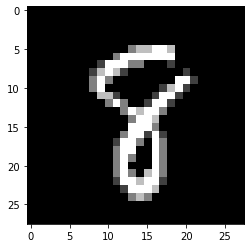

In [4]:
MnistVisualizer.show_dataset_examples(mnist_data_loader.trainloader)

# II. Class Activation Map (CAM)

Class Activation Map (CAM) refers to the weighted activation maps generated for an image of interest. CAM only supports CNNs which consist of blocks of CONV layers followed by a single AVGPOOL layer. The output from the AVGPOOL layer is then fed into a single DENSE layer which acts as a classifier. If the model under test does not have the described architecture, the last two layers should be additionally added and this part of the network should be additionally trained. 

<br>
<center>
  <p float="left">
    <img src="./assets/cam_formula.png"/>
  </p>
</center>

CAM is computed by multiplying the activation maps from the very last CONV layer by the weights of the DENSE classification layer for the chosen class. The low-resolution map is then upsampled to the size of the input image. The input image and the generated CAM are then being shown together to showcase the parts of the image which have had the highest importance for the classified class.

In [5]:
def generate_cams(dataloader, interpreter):
    images = []
    cams = []

    for i in range(10):
        img = dataloader.get_image_for_class(i)
        cam = interpreter.interpret(img)

        images.append(img.cpu().numpy().reshape(28, 28))
        cams.append(cam.numpy().reshape(28, 28))
    
    return images, cams

In [6]:
def display_cams(images, cams):
    for i in range(5):
        plt.figure(figsize=(10, 10))
        for j in range(2):
            plt.subplot(5, 2, i * 2 + j + 1)
            plt.imshow(images[i*2 + j], cmap='gray')
            plt.imshow(cams[i*2 + j], alpha=0.4)
            plt.title('Digit {} CAM'.format(i * 2 + j))
            plt.colorbar()
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()

## 1. CAM with model with small last activation maps (3x3)

In the first case, we will experiment with a model which produces activation maps in it's last CONV layer of size `128x3x3`. Upon the multiplication with the weight from the DENSE layer, we are left with a CAM of size `3x3`, which needs to be upsampled back to the input space which is of size `28x28`. Despite our attempts with different upsampling methods the huge gap in the sizes lead to rather bad results.

In [7]:
model = ModelRepository.get_cam_classifier(model_name)

if train:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    model.train()
    ModelTrainer.train(model, criterion, optimizer, trainloader)
    
    ModelRepository.save(model, model_name)

### 1.1. Bilinear upsampling

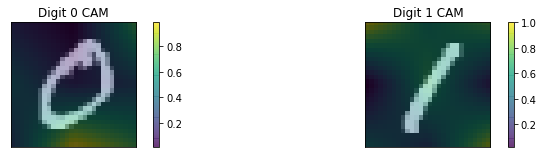

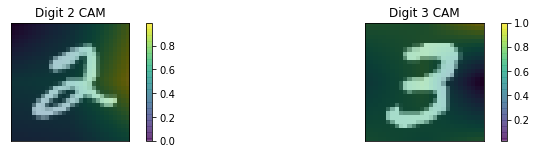

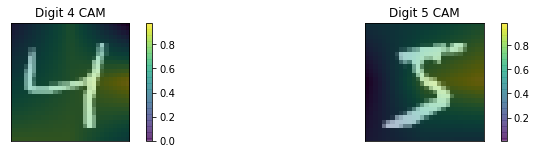

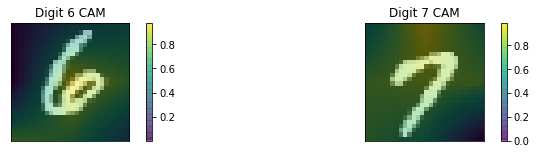

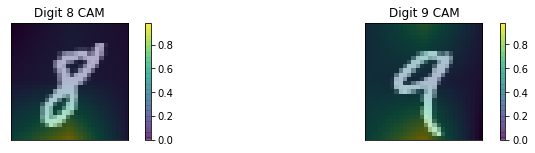

In [8]:
finalconv_name = 'relu3'
classes = [str(i) for i in range(10)]
interpreter = CAMInterpreter(model, classes, None, (28, 28), finalconv_name, "bilinear")

images, cams = generate_cams(mnist_data_loader, interpreter)

display_cams(images, cams)

### 1.2. Bicubic upsampling

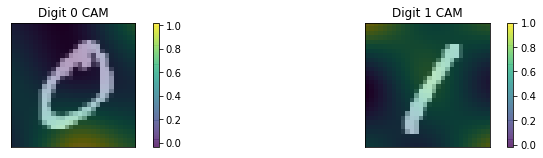

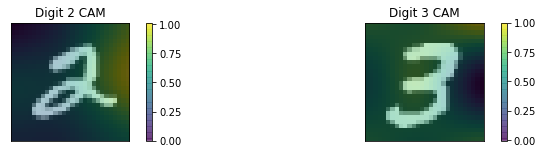

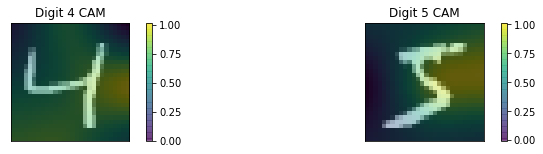

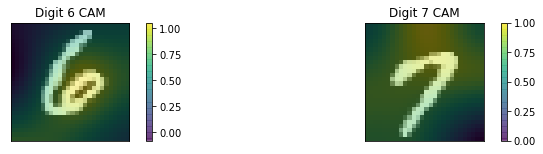

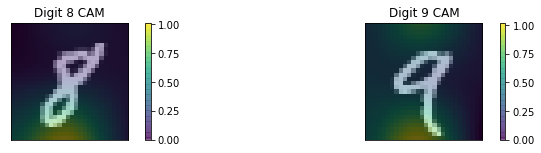

In [9]:
finalconv_name = 'relu3'
classes = [str(i) for i in range(10)]
interpreter = CAMInterpreter(model, classes, None, (28, 28), finalconv_name, "bicubic")

images, cams = generate_cams(mnist_data_loader, interpreter)

display_cams(images, cams)

## 2 CAM with model with medium-sized last activation maps (6x6)

In the second case, we will experiment with a model which produces activation maps in it's last CONV layer of size `128x6x6` leading to `6x6` CAMs before the upsampling. The increase of size does produce a better and more clear result.

In [10]:
model = ModelRepository.get_cam_extended_classifier(extended_model_name)

if train:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    model.train()
    ModelTrainer.train(model, criterion, optimizer, trainloader)
    
    ModelRepository.save(model, extended_model_name)

### 2.1. Bilinear upsampling

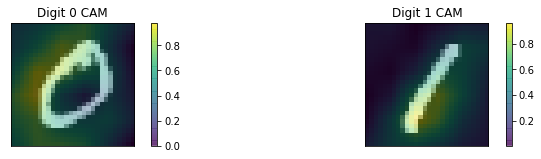

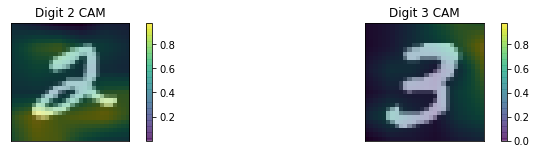

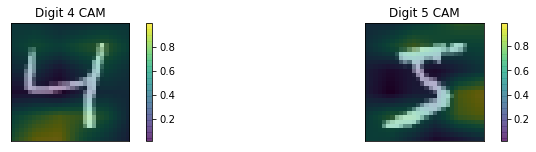

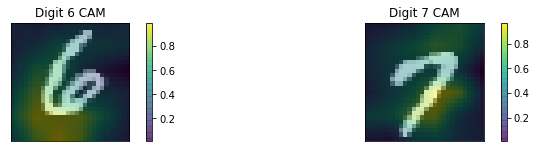

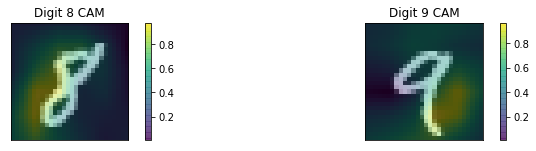

In [11]:
finalconv_name = 'relu3'
classes = [str(i) for i in range(10)]

interpreter = CAMInterpreter(model, classes, None, (28, 28), finalconv_name, "bilinear")
images, cams = generate_cams(mnist_data_loader, interpreter)

display_cams(images, cams)

### 2.2. Bicubic upsampling

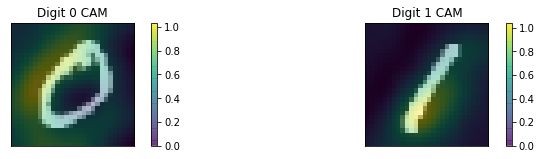

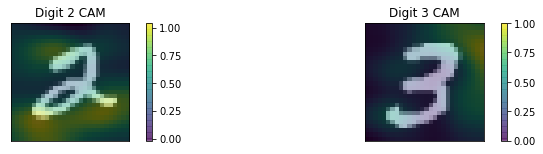

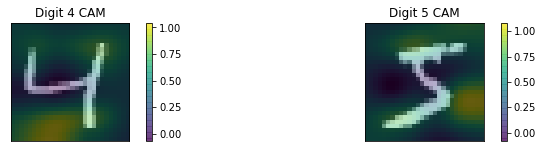

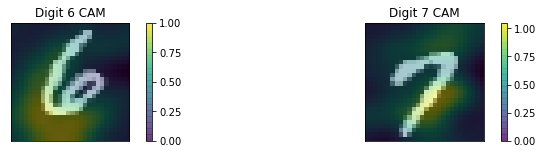

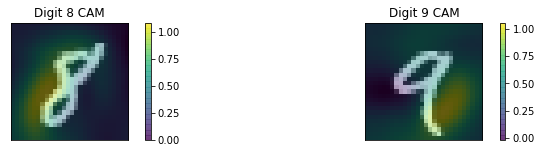

In [12]:
finalconv_name = 'relu3'
classes = [str(i) for i in range(10)]

interpreter = CAMInterpreter(model, classes, None, (28, 28), finalconv_name, "bicubic")
images, cams = generate_cams(mnist_data_loader, interpreter)

display_cams(images, cams)